In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
from torch import optim, nn
from sklearn.linear_model import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, roc_auc_score
torch.multiprocessing.set_sharing_strategy('file_system')
import numpy as np
import pandas as pd
import monai
from monai.config import print_config
from monai.data import DataLoader, list_data_collate
from monai.transforms import *
import warnings
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
warnings.filterwarnings('ignore')
with torch.no_grad(): torch.cuda.empty_cache()

SEED = 42

# choose if it should use full head CT or just masked images
MASKED = False


OG = True

torch.manual_seed(SEED)
monai.utils.set_determinism(seed=SEED, additional_settings=None)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_num_threads(1)
np.random.seed(SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


print('---------')




if MASKED: 
    folder_path = "Dataset/voxel_standard_masked"
else:
    folder_path = "Dataset/voxel_standard_fullhead"
print('FOLDER_PATH: ', folder_path)

print('---------')

# Load Test
filename = f'fold_og_test.xlsx'
dftest = pd.read_excel(filename, index_col=0)
dftest['img'] = [os.path.join(folder_path, f"{x}.nii.gz") 
            for x in dftest.index]
dftest = dftest.dropna()

model_output = pd.DataFrame({"MRN": dftest.index})
model_output['labels'] = dftest['label'].tolist()


# ------------------ 
# Load TrainVal File
# Fold
for FOLD in range(5):
    if OG: 
        filename = f'fold_og_{FOLD}.xlsx'
    else: 
        filename = f'fold_{FOLD}.xlsx'
    print('FILENAME: ', filename)
    dataset = pd.read_excel(filename, index_col=0)
    dataset = dataset.dropna()
    dataset['img'] = [os.path.join(folder_path, f"{x}.nii.gz") 
                for x in dataset.index]
    dfval = dataset[dataset.train == 0]

    ######## LOAD MODEL #####
    # Modellarchitektur definieren
    resnet_model=monai.networks.nets.resnet50(
        pretrained=False,
        spatial_dims=3,
        n_input_channels=1, 
        num_classes=1)
    CHECKPOINTS = [
            "Collection/version_3033490/c-epoch=167-val_loss_epoch=tensor(0.5776, device='cuda_0').ckpt",
            "Collection/version_3033525/c-epoch=167-val_loss_epoch=tensor(0.6086, device='cuda_0').ckpt",
            "Collection/version_3033567/c-epoch=281-val_loss_epoch=tensor(0.5935, device='cuda_0').ckpt",
            "Collection/version_3033675/c-epoch=69-val_loss_epoch=tensor(0.6515, device='cuda_0').ckpt",
            "Collection/version_3033705/c-epoch=133-val_loss_epoch=tensor(0.6156, device='cuda_0').ckpt"
        ]
    ckpt = CHECKPOINTS[FOLD]
    checkpoint = torch.load(ckpt)
    weights_dict = {k.replace('_model.', ''): v for k, v in checkpoint['state_dict'].items()}
    model_dict = resnet_model.state_dict()
    model_dict.update(weights_dict)
    resnet_model.load_state_dict(model_dict)

    # delete last layer
    resnet = torch.nn.Sequential(*list(resnet_model.children())[:-1])

    #
    #
    # TURN FOLLOWING ON FOR OUTPUT 1: 
    #
    #
    resnet = resnet_model 

    # Set the model to evaluation mode
    resnet.eval()

    val_files =  [{"img": img,
                    "label": label,
                    "clinical":clinical} for 
                    img, label, clinical in 
                    zip(dfval['img'],
                        dfval.label,
                        dfval[['TICI','LKN_CTA_time','CTA_Angio_time']].to_numpy())]
    test_files =  [{"img": img,
                    "label": label,
                    "clinical":clinical} for 
                    img, label, clinical in 
                    zip(dftest['img'],
                        dftest.label,
                        dftest[['TICI','LKN_CTA_time','CTA_Angio_time']].to_numpy())]
    transforms_valtest = Compose(
        [
            LoadImaged(keys=["img"], ensure_channel_first=True),
            ToTensord(keys=['img'])

        ]
    )
    val_ds = monai.data.Dataset(data=val_files, transform=transforms_valtest)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

    test_ds = monai.data.Dataset(data=test_files, transform=transforms_valtest)
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

    all_features = []
    all_labels = []
    i = 0
    for batch in val_loader:
        # Move the input data to the training device
        img, clinical, labels = batch['img'].to(device), batch['clinical'].to(device), batch['label'].to(device)
        
        with torch.no_grad():
            # Assuming you have already defined and loaded the pre-trained ResNet model
            resnet = resnet.to(device)
            
            features = resnet(img)
            features = features.view(1, -1)
            
            clinical_data = clinical
            
            combined_features = torch.cat((features, clinical_data), dim=1)
            all_features.append(combined_features.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
            
        i = i + 1
        #print('VALSET FEATURE', i)

    X = np.vstack(all_features)
    y = np.vstack(all_labels)



    # Test set
    all_features = []
    all_labels = []
    i = 0
    for batch in test_loader:
        # Move the input data to the training device
        img, clinical, labels = batch['img'].to(device), batch['clinical'].to(device), batch['label'].to(device)
        
        with torch.no_grad():
            # Assuming you have already defined and loaded the pre-trained ResNet model
            resnet = resnet.to(device)
            
            features = resnet(img)
            features = features.view(1, -1)
            
            clinical_data = clinical
            
            combined_features = torch.cat((features, clinical_data), dim=1)
            all_features.append(combined_features.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())
            
        i = i + 1
        #print('TEST FEATURES', i)

    Xtest = np.vstack(all_features)
    ytest = np.vstack(all_labels)

    clf = LogisticRegression(random_state=42).fit(X, y)
    preds = clf.predict_proba(Xtest)
    print('LR: ', roc_auc_score(ytest.T[0], preds.T[1]))
    model_output[f'output_{FOLD}'] = preds.T[1]



---------
FOLDER_PATH:  Dataset/voxel_standard_fullhead
---------
FILENAME:  fold_og_0.xlsx
LR:  0.7216183574879227
FILENAME:  fold_og_1.xlsx
LR:  0.783816425120773
FILENAME:  fold_og_2.xlsx
LR:  0.7463768115942029
FILENAME:  fold_og_3.xlsx
LR:  0.732487922705314
FILENAME:  fold_og_4.xlsx
LR:  0.7270531400966184


          MRN  labels  output_0  output_1  output_2  output_3  output_4
0   MR6052759       0  0.551542  0.543171  0.779977  0.635933  0.426957
1     MR95457       1  0.911042  0.846109  0.813807  0.865232  0.624598
2    MR278840       0  0.647211  0.601699  0.592074  0.497594  0.665371
3   MR2412133       1  0.732079  0.636458  0.573784  0.577648  0.608542
4   MR5821734       1  0.565659  0.531679  0.256113  0.578586  0.656747
..        ...     ...       ...       ...       ...       ...       ...
90   MR656895       1  0.213070  0.739779  0.775899  0.829898  0.500408
91  MR6499221       1  0.946090  0.929930  0.902820  0.826864  0.978733
92  MR4681252       1  0.694466  0.569410  0.620010  0.617984  0.630543
93  MR4186791       1  0.946926  0.897859  0.802511  0.732150  0.884943
94  MR2939649       0  0.775937  0.660963  0.648989  0.587975  0.824070

[95 rows x 7 columns]
              precision    recall  f1-score   support

           0       0.67      0.17      0.28        23
    

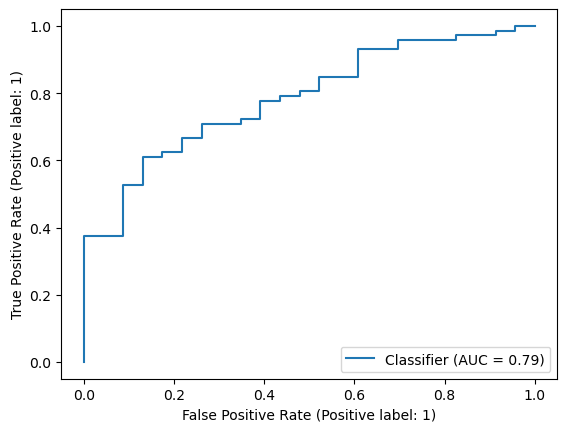

In [3]:
model_output.to_csv('img_treat-preds.csv')
model_output = pd.read_csv('img_treat-preds.csv', index_col=0)
model_output.set_index('MRN', inplace=True)
labels = model_output.pop('labels')
def checkoutput(n, thr):
    if n >= thr:
        return 1
    else: return 0

from sklearn.metrics import classification_report
# Mean vote
model_output['mean_prob'] = model_output.mean(axis=1)
RocCurveDisplay.from_predictions(labels, model_output.mean_prob)

model_output['decision'] = [checkoutput(i, 0.50) for i in model_output.mean_prob]
print(classification_report(labels, model_output.decision))
model_output['labels'] = labels
model_output.to_csv('img_treat-preds.csv')

           output_0  output_1  output_2  output_3  output_4  mean_prob  \
MRN                                                                      
MR6052759  0.551542  0.543171  0.779977  0.635933  0.426957   0.646442   
MR95457    0.911042  0.846109  0.813807  0.865232  0.624598   0.838992   
MR278840   0.647211  0.601699  0.592074  0.497594  0.665371   0.657820   
MR2412133  0.732079  0.636458  0.573784  0.577648  0.608542   0.679173   
MR5821734  0.565659  0.531679  0.256113  0.578586  0.656747   0.586649   
...             ...       ...       ...       ...       ...        ...   
MR656895   0.213070  0.739779  0.775899  0.829898  0.500408   0.667267   
MR6499221  0.946090  0.929930  0.902820  0.826864  0.978733   0.928761   
MR4681252  0.694466  0.569410  0.620010  0.617984  0.630543   0.679842   
MR4186791  0.946926  0.897859  0.802511  0.732150  0.884943   0.873895   
MR2939649  0.775937  0.660963  0.648989  0.587975  0.824070   0.742503   

           decision  output_0_class  

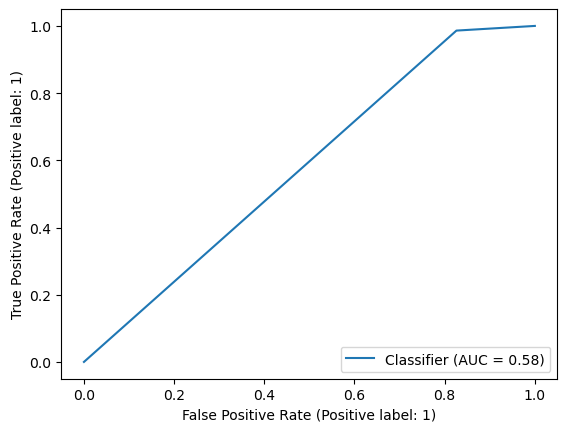

In [15]:
# Majority
for i in range(5):
    model_output[f'output_{i}_class'] = [checkoutput(i, 0.50) for i in model_output[f'output_{i}']]
def voting(df, MRN):
    l = list()
    for i in range(5):
        l.append(df.loc[MRN, f'output_{i}_class'])
    if sum(l) > 2: return 1
    else: return 0
model_output['decision'] = [voting(model_output,mrn) for mrn in model_output.index]
print(model_output)
score = roc_auc_score(labels, model_output.decision)
print(f"ROC AUC: {score:.4f}")
print(classification_report(labels, model_output.decision))
RocCurveDisplay.from_predictions(labels, model_output.decision)

In [8]:

# Logistic regression analysis
import statsmodels.api as sm
Xlogit = sm.add_constant(X)
logit_model=sm.Logit(y,Xlogit)
result=logit_model.fit()
print(result.summary())




Optimization terminated successfully.
         Current function value: 0.578453
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   99
Model:                          Logit   Df Residuals:                       94
Method:                           MLE   Df Model:                            4
Date:                Mon, 10 Jul 2023   Pseudo R-squ.:                  0.1008
Time:                        16:39:14   Log-Likelihood:                -57.267
converged:                       True   LL-Null:                       -63.685
Covariance Type:            nonrobust   LLR p-value:                   0.01210
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3780      0.715      0.529      0.597      -1.023       1.779
x1             1.2851      0.

In [ ]:
clf = RandomForestClassifier(
    max_depth=11, 
    random_state=42,
    criterion="gini").fit(X,y)
preds = clf.predict_proba(Xtest)
print('RF: ', roc_auc_score(ytest.T[0], preds.T[1]))



In [ ]:
clf = Lasso(alpha=0.1).fit(X,y)
preds = clf.predict(Xtest)
print('Lasso: ', roc_auc_score(ytest.T[0], preds))



In [ ]:
# XGBOOST
import xgboost as xgb
dtrain = xgb.DMatrix(X, label=y)
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
num_round = 10
bst = xgb.train(param, dtrain, num_round)

dtest = xgb.DMatrix(Xtest, label=ytest)
preds = bst.predict(dtest)
print('XGBoost: ', roc_auc_score(ytest.T[0], preds))